## 3. MODELLING

### 3.1 - Generalized Least Squares for Autocorrelation (GLSAR)

In [1]:
# Load the packages and other tools
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import shap
import numpy as np
import pickle
import tensorflow as tf
from datetime import datetime
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn import metrics
from keras import optimizers
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\sofia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\sofia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Reading the model dataset
model = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx',index_col=0)

#Check the first observations
model.head(2)

,lg_price,lg_market-cap,lg_trade-volume,lg_transaction-fees-usd,lg_avg-confirmation-time,lg_difficulty,lg_High,lg_Low,lg_hash-rate,block-size,...,n-transactions-per-block,lg_output-volume,lg_Gold,News Regulation,GT_legal,GT_cryptocurrency,GT_scam,lg_SP500,lg_Oil,Theft
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,6.921086,23.527405,15.376856,11.651582,2.566197,1.94591,6.921086,6.862863,14.767149,97293.875547,...,272924.1,14.342027,7.083472,0,1.0,2,1,7.729786,3.961004,1
2017-01-02,6.921086,23.527405,15.376856,11.651582,4.578962,1.94591,6.938963,6.897907,14.767149,97293.875547,...,272924.1,14.342027,7.083472,0,1.0,2,1,7.729786,3.961004,0


* Data pre-processing

*To obtain BLUE estimators, it is necessary to respect the Gauss-Markov assumptions. Therefore, a data pre-processing will be made especifically to GLS.*

In [3]:
# Remove the variables with perfect collinearity with y that comprilead to lead to multicollinearity 
model= model.drop(['lg_Low','lg_Open'],axis=1)

# Avoiding data leakage
model= model.drop(['lg_High'],axis=1)

# Creating a dummy variable for GT means that it is necessary to drop one of the categories
model= model.drop(['GT_scam'],axis=1)

# Deleting the ratios that have variables included in the model in order to avoid very similar information
model= model.drop(['n-transactions-per-block','lg_cost-per-transaction-percent','lg_fees-usd-per-transaction','n-payments-per-block'],axis=1) 

# Dropping 'block-size' because of its perfect collinearity with n-transactions-total (The later is fundamental to the analysis. Thus, it needs to remain in the equation.)
model= model.drop(['block-size'],axis=1)

# Deleting transaction-based variables that are not statistically significant
model= model.drop(['lg_avg-confirmation-time','lg_circulatingBTC'],axis=1)
model.head(2)

,lg_price,lg_market-cap,lg_trade-volume,lg_transaction-fees-usd,lg_difficulty,lg_hash-rate,lg_miners-revenue,n-transactions-total,lg_Popularity,n-unique-addresses,lg_output-volume,lg_Gold,News Regulation,GT_legal,GT_cryptocurrency,lg_SP500,lg_Oil,Theft
Timestamp,,,,,,,,,,,,,,,,,,
2017-01-01,6.921086,23.527405,15.376856,11.651582,1.94591,14.767149,14.575693,183961799.0,7,13.057525,14.342027,7.083472,0,1.0,2,7.729786,3.961004,1
2017-01-02,6.921086,23.527405,15.376856,11.651582,1.94591,14.767149,14.575693,183961799.0,7,13.057525,14.342027,7.083472,0,1.0,2,7.729786,3.961004,0


* Model formulation

In [4]:
# Check the dimensions of the model dataset
print(model.shape)

(1615, 18)


In [5]:
import statsmodels.api as sm
# Define the variables
model_exog=model.iloc[:,1:31]

# Put the target (lg_price) in another DataFrame
model_endog = model["lg_price"]
model_endog.sort_index(ascending=True)

# Add a constant to the explanatory variables
model_exog = sm.add_constant(model_exog) # let's add an intercept (beta_0) to our model
model_exog.sort_index(ascending=True)

,const,lg_market-cap,lg_trade-volume,lg_transaction-fees-usd,lg_difficulty,lg_hash-rate,lg_miners-revenue,n-transactions-total,lg_Popularity,n-unique-addresses,lg_output-volume,lg_Gold,News Regulation,GT_legal,GT_cryptocurrency,lg_SP500,lg_Oil,Theft
Timestamp,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,23.527405,15.376856,11.651582,1.945910,14.767149,14.575693,1.839618e+08,7,13.057525,14.342027,7.083472,0,1.0,2,7.729786,3.961004,1
2017-01-02,1.0,23.527405,15.376856,11.651582,1.945910,14.767149,14.575693,1.839618e+08,7,13.057525,14.342027,7.083472,0,1.0,2,7.729786,3.961004,0
2017-01-03,1.0,23.527405,15.376856,11.651582,1.945910,14.767149,14.575693,1.839618e+08,7,13.057525,14.342027,7.083472,0,1.0,2,7.729786,3.961004,0
2017-01-04,1.0,23.590040,15.583291,11.651582,1.945910,14.748687,14.575693,1.839618e+08,7,13.098717,14.402047,7.083472,0,1.0,2,7.729786,3.961004,0
2017-01-05,1.0,23.590040,15.583291,11.711432,1.945910,14.579937,14.513546,1.848845e+08,7,13.098717,14.402047,7.083472,0,1.0,2,7.729786,3.961004,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,1.0,20.478735,20.569115,15.233616,3.713572,18.901268,20.280450,6.422254e+08,41,13.447443,14.517931,7.523081,0,4.0,26,8.335570,4.244487,0
2021-06-01,1.0,20.496639,20.555220,15.197400,3.713572,18.898910,20.280842,6.424775e+08,41,13.443656,14.509932,7.514565,0,4.0,26,8.351962,4.244487,0
2021-06-02,1.0,20.788734,20.560902,15.171042,3.713572,18.890411,20.281233,6.427285e+08,41,13.444998,14.509911,7.514565,0,4.0,26,8.351962,4.244487,0


In [6]:
# Splitting into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(model_exog, model_endog, test_size=0.2,shuffle=False)

print('Training data set size :', y_train.shape[0])
print('Test data set size :', y_test.shape[0])

Training data set size : 1292
Test data set size : 323


In [7]:
glsar_model = sm.GLSAR(model_endog, model_exog, 2)
glsar_results = glsar_model.iterative_fit(2,(X_train,y_train),validation_split=0.2)
print(glsar_results.summary())

                           GLSAR Regression Results                           
Dep. Variable:               lg_price   R-squared:                       0.916
Model:                          GLSAR   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     1022.
Date:                Fri, 30 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:21:56   Log-Likelihood:                 2333.9
No. Observations:                1613   AIC:                            -4632.
Df Residuals:                    1595   BIC:                            -4535.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [8]:
## Variance Inflation Factors (VIF) TEST
# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = model_exog.iloc[:,1:]
    # the calculation of variance inflation requires a constant
    X['intercept'] = model_exog['const']
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [9]:
# features to consider removing
considered_features = model_exog.iloc[:,1:]
# compute vif 
compute_vif(considered_features).sort_values('VIF', ascending=True)

,Variable,VIF
16,Theft,1.011046
11,News Regulation,1.019639
0,lg_market-cap,3.062619
9,lg_output-volume,3.196707
15,lg_Oil,3.795908
1,lg_trade-volume,4.084614
8,n-unique-addresses,4.344348
12,GT_legal,6.821718
2,lg_transaction-fees-usd,8.375092
13,GT_cryptocurrency,9.236816


*The group of variables from News Regulation until n-unique-addresses represent the acceptable ones for this model because they are below 5, the critical multicollinearity value.*

* Predicting

In [10]:
# Predicting the first 5 values of lg_price
predictions=glsar_results.predict(X_test)
predictions

Timestamp
2020-07-16     9.127681
2020-07-17     9.095328
2020-07-18     9.115329
2020-07-19     9.060744
2020-07-20     9.106459
                ...    
2021-05-31    10.774523
2021-06-01    10.796660
2021-06-02    10.835893
2021-06-03    10.877733
2021-06-04    10.892717
Length: 323, dtype: float64

* Evaluation

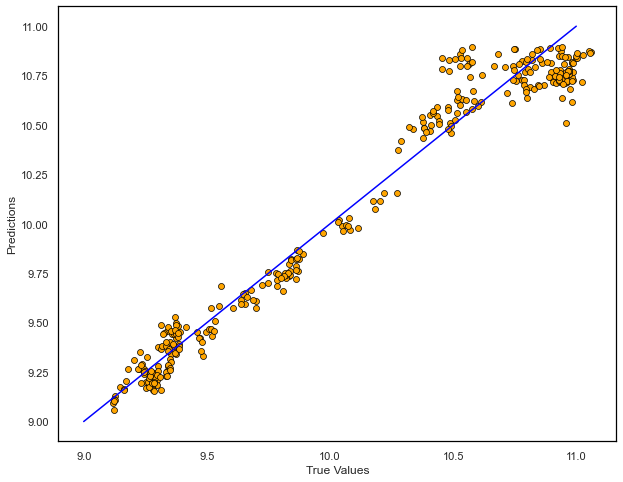

In [11]:
## The line / model
sns.set(rc = {'figure.figsize':(10,8)})
plt.plot(range(9,12),range(9,12),color='blue')
plt.scatter(y_test, predictions,edgecolors='black',linewidths=0.7,color='orange')
plt.grid(b=None) # Hide grid lines
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Setting the background color of the plot to white
ax = plt.axes()
ax.set_facecolor("white")
ax.spines['left'].set_color('black') 
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')

plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/linear_reg_predictionsVStrue.jpeg') # Save the picture
plt.show()

*The limitation of train/test split is if, by chance, the split made was not random.* 

*This will result in overfitting, even though it was tried to avoid it. Therefore, it is introduced validation.*

In [12]:
# 1. MSE - Mean Squared Error
MSE = np.square(np.subtract(y_test,predictions)).mean() 
print("Mean Square Error: ", MSE)

# 2. RMSE - Root Mean Square Error
RMSE = math.sqrt(MSE)
print("Root Mean Square Error: ", RMSE)

# 3. sMAPE - symmetric Mean Absolute Percentage Error
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))
sMAPE=smape(y_test,predictions)
print('sMAPE: ',sMAPE)

# 4. R^2 score
r2_score = metrics.r2_score(y_test, predictions)
print('R^2 score: ',r2_score)

Mean Square Error:  0.016803364711370828
Root Mean Square Error:  0.12962779297423385
sMAPE:  0.009797369503901728
R^2 score:  0.9626131718839481


In [13]:
# Defining a dictionary
d = {'Model': ['GLS'],'MSE': [MSE],'RMSE':[RMSE],'sMAPE':[sMAPE],'R^2 score': [r2_score]}

# Creating a dataframe to compare the evaluation metrics results of the 2 models
metric=pd.DataFrame(d, index=[0,])
metric.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/metrics/metrics.xlsx')
metric

,Model,MSE,RMSE,sMAPE,R^2 score
0,GLS,0.016803,0.129628,0.009797,0.962613


* Analysis

In [31]:
coefficients = glsar_results.params
coefficients=pd.DataFrame(coefficients)
coefficients.rename(columns={ coefficients.columns[0]: "coefficient" }, inplace = True)
coefficients

,coefficient
const,-1.387888e+01
lg_market-cap,1.318720e-01
lg_trade-volume,1.524687e-02
lg_transaction-fees-usd,2.506546e-02
lg_difficulty,2.070717e-01
lg_hash-rate,-8.082794e-02
lg_miners-revenue,3.207399e-01
n-transactions-total,2.111999e-09
lg_Popularity,-5.388934e-03
n-unique-addresses,-4.199408e-02


In [15]:
external=coefficients.loc[["lg_Gold",'News Regulation', 'GT_legal','GT_cryptocurrency','Theft','lg_Oil','lg_SP500','lg_Popularity']]

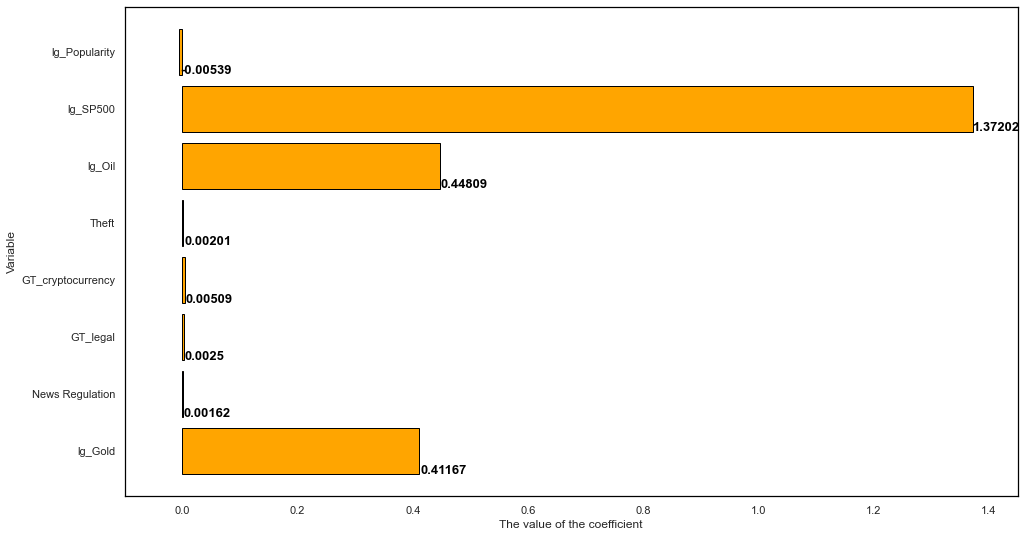

In [25]:
## Creatinga horizontal bar plot to visualize the external coefficients
# Figure Size
fig, ax = plt.subplots(figsize=(16, 9))
 
# Horizontal Bar Plot
ax.barh(external.index,external['coefficient'],color='orange',edgecolor='black',data=external)

# Adding annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.001, i.get_y()+0.011,
             str(round((i.get_width()), 5)),
             fontsize = 13, fontweight ='bold',
             color ='black')
    
# Adding labels to the axis
plt.ylabel('Variable')
plt.xlabel('The value of the coefficient')

# Setting the x limit
plt.xlim(-0.1,1.45)

# Hide grid lines
ax.grid(False)


# Setting the background color of the plot to white
ax.set_facecolor("white")
ax.spines['left'].set_color('black') 
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')

plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/hbar_plot_externalcoeff.jpeg') # Save the picture

In [36]:
features=coefficients.drop(['const'],axis=0)
features = features.sort_values('coefficient', ascending=True)

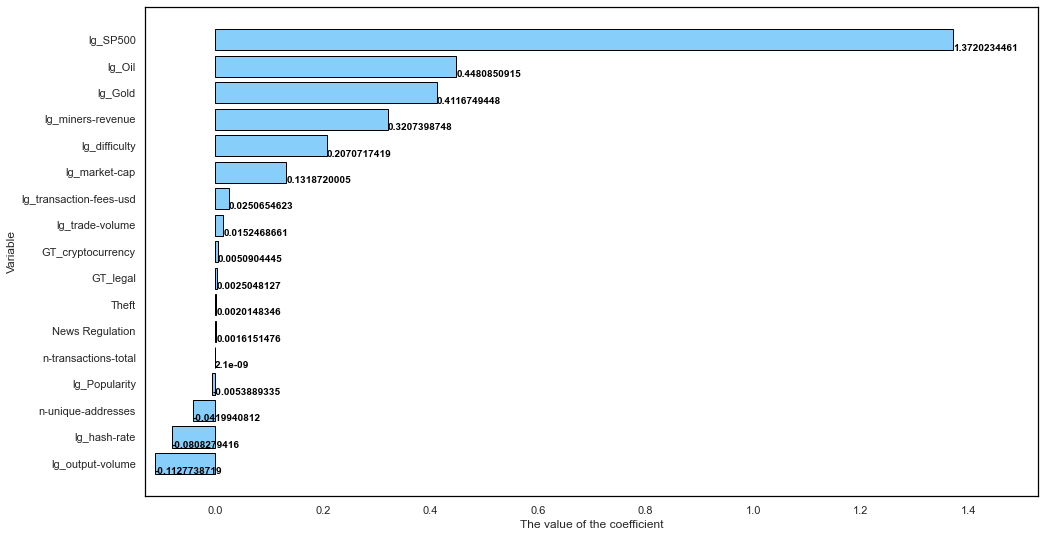

In [37]:
## Creating a horizontal bar plot to visualize the external coefficients
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(features.index,features['coefficient'],edgecolor='black',data=features,color='lightskyblue')

# Adding labels to the axis
plt.ylabel('Variable')
plt.xlabel('The value of the coefficient')

# Setting the x limit
plt.xlim(-0.13,1.53)

# Adding annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.00011, i.get_y()+0.000111,
             str(round((i.get_width()), 10)),
             fontsize = 10, fontweight ='bold',
             color ='black')
# Hide grid lines
ax.grid(False)


# Setting the background color of the plot to white
ax.set_facecolor("white")
ax.spines['left'].set_color('black') 
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')

plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/hbar_plot_all.jpeg') # Save the picture